In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
min_data_value = "2000-01-01"
max_data_value = "2020-01-01"

In [30]:
symbols = pd.read_csv('data/symbols_valid_meta.csv')
symbols = symbols[symbols['ETF'] == 'N'] # keep only stocks 
symbols.head()

,Nasdaq Traded,Symbol,Security Name,Listing Exchange,Market Category,ETF,Round Lot Size,Test Issue,Financial Status,CQS Symbol,NASDAQ Symbol,NextShares
0,Y,A,"Agilent Technologies, Inc. Common Stock",N,,N,100.0,N,NaN,A,A,N
1,Y,AA,Alcoa Corporation Common Stock,N,,N,100.0,N,NaN,AA,AA,N
3,Y,AACG,ATA Creativity Global - American Depositary Sh...,Q,G,N,100.0,N,N,NaN,AACG,N
5,Y,AAL,"American Airlines Group, Inc. - Common Stock",Q,Q,N,100.0,N,N,NaN,AAL,N
6,Y,AAMC,Altisource Asset Management Corp Com,A,,N,100.0,N,NaN,AAMC,AAMC,N


In [31]:
print(f'Number of stocks: {symbols.count()["Symbol"]}')

Number of stocks: 5884


In [32]:
# Focus on 'G' segment
g_segment = symbols[symbols['Market Category'] == 'G']
print(f'Number of stocks in G segment: {g_segment.count()["Symbol"]}')

Number of stocks in G segment: 505


In [33]:
# Check historical data availability and reduce stock list

g_segment_selected = []

for symbol in g_segment['Symbol']:
    hist_data_tmp = pd.read_csv(f'data/stocks/{symbol}.csv')
    min_date = hist_data_tmp['Date'].min()
    max_date = hist_data_tmp['Date'].max()
    if min_date <= min_data_value and max_date >= max_data_value:
        g_segment_selected.append(symbol)

print(f'Number of stocks in G segment with sufficient historical data: {len(g_segment_selected)}')

Number of stocks in G segment with sufficient historical data: 129


In [34]:
volume_list = {}

# Get volume between 1 janv 2000 and 1 janv 2002
# Calculate average volume
# Compare to median volume and keep those above median

min_data_value_volume = min_data_value
max_date_value_volume = "2002-01-01"

for symbol in g_segment_selected:
    hist_data_tmp = pd.read_csv(f'data/stocks/{symbol}.csv')
    hist_data_tmp = hist_data_tmp[(hist_data_tmp['Date'] >= min_data_value_volume) & (hist_data_tmp['Date'] <= max_date_value_volume)]
    avg_volume = hist_data_tmp['Volume'].mean()
    volume_list[symbol] = avg_volume

volume_above_median = []
median_volume = np.median(list(volume_list.values()))

for symbol, avg_volume in volume_list.items():
    if avg_volume > median_volume:
        volume_above_median.append(symbol)

volume_above_median = sorted(volume_above_median)

print(f'Number of stocks in G segment with volume above median: {len(volume_above_median)}')

Number of stocks in G segment with volume above median: 64


In [45]:
initial_data = pd.DataFrame()

for symbol in volume_above_median:
    hist_data_tmp = pd.read_csv(f'data/stocks/{symbol}.csv')
    hist_data_tmp = hist_data_tmp[(hist_data_tmp['Date'] >= min_data_value) & (hist_data_tmp['Date'] <= max_data_value)]
    hist_data_tmp = hist_data_tmp[['Date','Open','High','Low','Close','Adj Close','Volume']].copy()

    hist_data_tmp["High_over_Low"] = hist_data_tmp["High"] / hist_data_tmp["Low"]
    hist_data_tmp["Day_yield"] = np.log(hist_data_tmp["Close"] / hist_data_tmp["Open"])

    hist_data_tmp = hist_data_tmp.drop(columns=['High','Low','Close','Open'])
    
    hist_data_tmp.rename(columns={'Adj Close': f'Adj_Close_{symbol}', 'Volume': f'Volume_{symbol}',
                                      'High_over_Low': f'High_over_Low_{symbol}', 'Day_yield': f'Day_yield_{symbol}'}, inplace=True)

    # if missing value then forward fill
    hist_data_tmp.ffill(inplace=True)

    if initial_data.empty:
        initial_data = hist_data_tmp
    else:
        initial_data = pd.merge(initial_data, hist_data_tmp, on='Date', how='inner')
initial_data.reset_index(drop=True, inplace=True)
initial_data.head()


,Date,Adj_Close_ALJJ,Volume_ALJJ,High_over_Low_ALJJ,Day_yield_ALJJ,Adj_Close_AMOT,Volume_AMOT,High_over_Low_AMOT,Day_yield_AMOT,Adj_Close_ASRV,...,High_over_Low_UNTY,Day_yield_UNTY,Adj_Close_WLFC,Volume_WLFC,High_over_Low_WLFC,Day_yield_WLFC,Adj_Close_WSTG,Volume_WSTG,High_over_Low_WSTG,Day_yield_WSTG
0,2000-01-05,27.250,182300,1.061611,-0.018182,1.526148,6000,1.076923,-0.074108,8.666723,...,1.0,0.0,6.3750,107300,1.030000,0.019803,2.826390,158500,1.070796,0.008811
1,2000-01-10,26.375,234400,1.043062,-0.004728,1.760940,0,1.000000,0.000000,8.710496,...,1.0,0.0,6.3750,11500,1.040000,0.019803,2.479289,33000,1.080000,-0.019803
2,2000-01-13,25.000,153600,1.035714,0.020203,1.643544,6000,1.000000,0.000000,8.360323,...,1.0,0.0,6.1875,9000,1.041667,0.030772,2.380118,70000,1.065217,0.000000
3,2000-01-14,26.000,709600,1.106796,-0.082997,1.643544,0,1.000000,0.000000,7.878839,...,1.0,0.0,6.8125,24300,1.120000,0.076227,2.330531,32800,1.065217,-0.041673
4,2000-01-18,24.875,481700,1.122449,-0.096908,1.643544,0,1.000000,0.000000,8.053927,...,1.0,0.0,6.7500,21000,1.028037,0.009302,2.454496,35600,1.086957,0.046520


<Axes: >

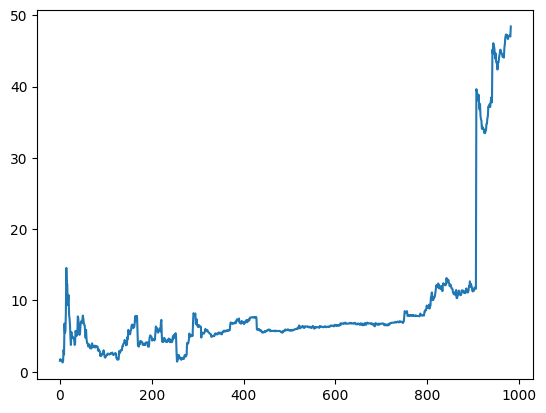

In [44]:
initial_data['Adj Close_AMOT'].plot()